# Denoising Diffusion Probabilistic Models with MedNIST Dataset

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

TODO: Add Open in Colab

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from tqdm import tqdm

# TODO: Add right import reference after deployed
from generative.networks.nets import DiffusionModelUNet
from generative.schedulers import DDPMScheduler

print_config()

MONAI version: 1.1.dev2239
Numpy version: 1.23.3
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For deta

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpk7m54jny


## Set deterministic training for reproducibility

In [4]:
set_determinism(0)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

MedNIST.tar.gz: 59.0MB [00:03, 16.4MB/s]                                                                                                                                                                                        

2022-11-04 20:39:47,731 - INFO - Downloaded: /tmp/tmpk7m54jny/MedNIST.tar.gz


2022-11-04 20:39:47,802 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-04 20:39:47,802 - INFO - Writing into directory: /tmp/tmpk7m54jny.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:13<00:00, 3408.83it/s]


In [6]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7999/7999 [00:04<00:00, 1794.04it/s]


In [7]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)

2022-11-04 20:40:10,773 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-04 20:40:10,774 - INFO - File exists: /tmp/tmpk7m54jny/MedNIST.tar.gz, skipped downloading.
2022-11-04 20:40:10,774 - INFO - Non-empty folder exists in /tmp/tmpk7m54jny/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7999/7999 [00:04<00:00, 1842.35it/s]


### Visualisation of the training images

batch shape: (128, 1, 64, 64)


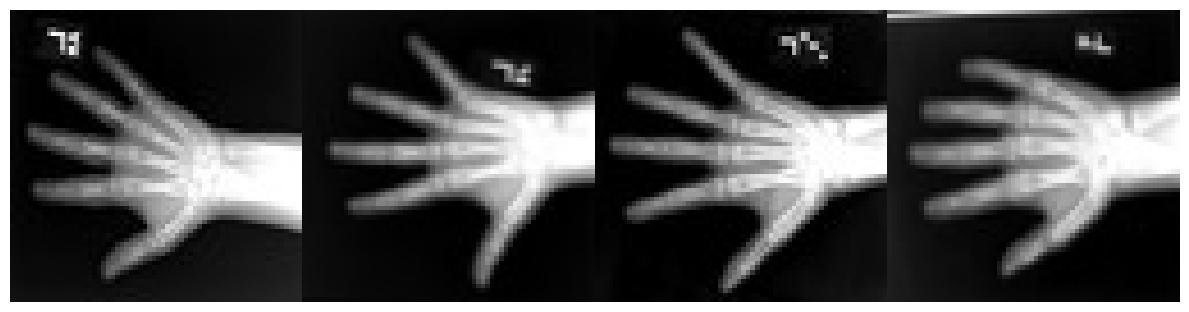

In [8]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.concat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler and optimizer
At this step, we instantiate the MONAI components to create a DDPM, the UNET and the noise scheduler. We are using
the original ddpm scheduler containing 1000 timesteps in its Markov chain, and a 2D unet with attention mechanisms
in the 2nd and 4th levels, each with 1 attention head.

In [9]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    model_channels=64,
    attention_resolutions=[2, 4],
    num_res_blocks=1,
    channel_mult=[1, 2, 2],
    num_heads=1,
)
model.to(device)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
)

optimizer = torch.optim.Adam(model.parameters(), 2.5e-5)

### Model training

Epoch 4 - Sampling...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.88it/s]


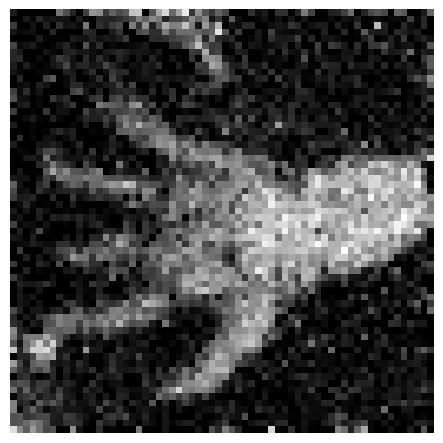

Epoch 9 - Sampling...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.72it/s]


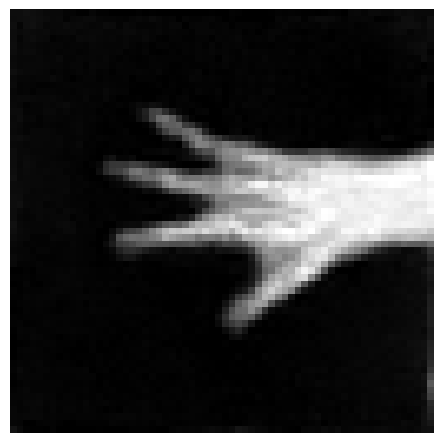

Epoch 14 - Sampling...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.08it/s]


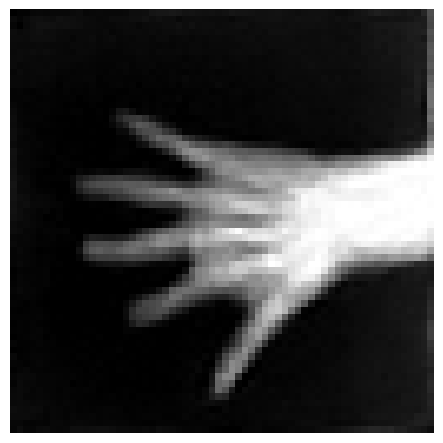

Epoch 19 - Sampling...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.14it/s]


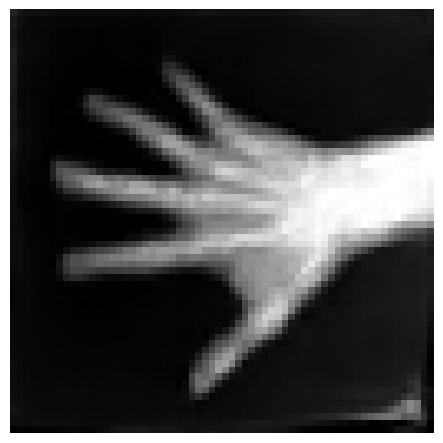

Epoch 24 - Sampling...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.86it/s]


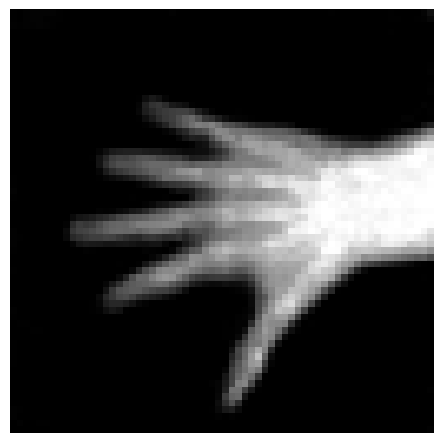

Epoch 29 - Sampling...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.24it/s]


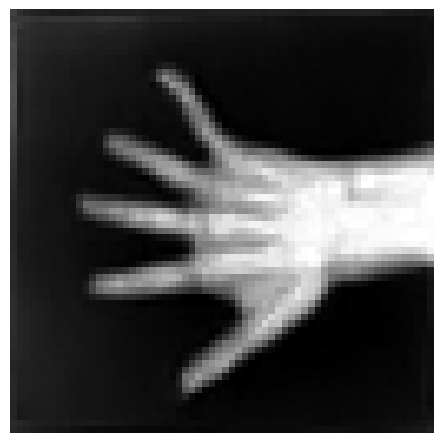

Epoch 34 - Sampling...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.83it/s]


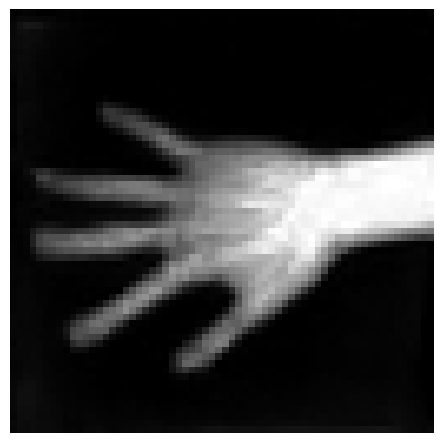

Epoch 39 - Sampling...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.88it/s]


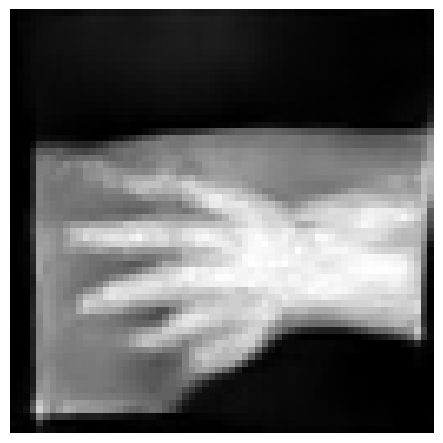

Epoch 44 - Sampling...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.87it/s]


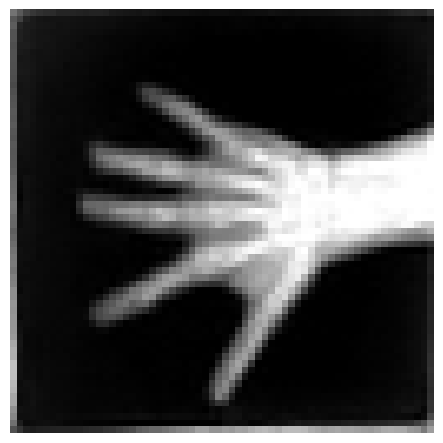

Epoch 49 - Sampling...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.54it/s]


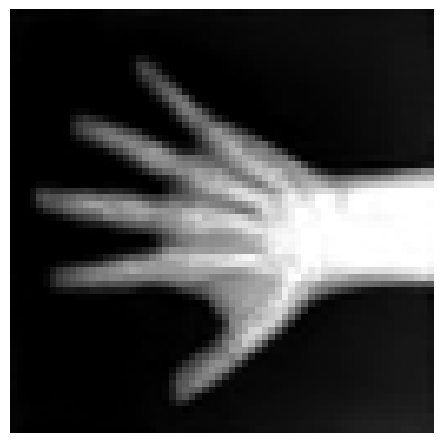

In [10]:
n_epochs = 50
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        # Randomly select the timesteps to be used for the minibacth
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (images.shape[0],), device=device).long()

        # Add noise to the minibatch images with intensity defined by the scheduler and timesteps
        noise = torch.randn_like(images).to(device)
        noisy_image = scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)

        # In this example, we are parametrising our DDPM to learn the added noise (epsilon).
        # For this reason, we are using our network to predict the added noise and then using L1 loss to predict
        # its performance.
        noise_pred = model(x=noisy_image, timesteps=timesteps)
        loss = F.l1_loss(noise_pred.float(), noise.float())

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        progress_bar = tqdm(enumerate(val_loader), total=len(train_loader))
        progress_bar.set_description(f"Epoch {epoch} - Validation set")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (images.shape[0],), device=device).long()
            noise = torch.randn_like(images).to(device)
            with torch.no_grad():
                noisy_image = scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)
                noise_pred = model(x=noisy_image, timesteps=timesteps)
                val_loss = F.l1_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix(
                {
                    "val_loss": val_epoch_loss / (step + 1),
                }
            )
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        image = torch.randn((1, 1, 64, 64))
        image = image.to(device)
        scheduler.set_timesteps(1000)
        progress_bar = tqdm(scheduler.timesteps)
        progress_bar.set_description(f"Epoch {epoch} - Sampling...")
        for t in progress_bar:
            # 1. predict noise model_output
            with torch.no_grad():
                model_output = model(image, torch.asarray((t,)).to(device))
            # 2. compute previous image: x_t -> x_t-1
            image, _ = scheduler.step(model_output, t, image)

        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

### Learning curves

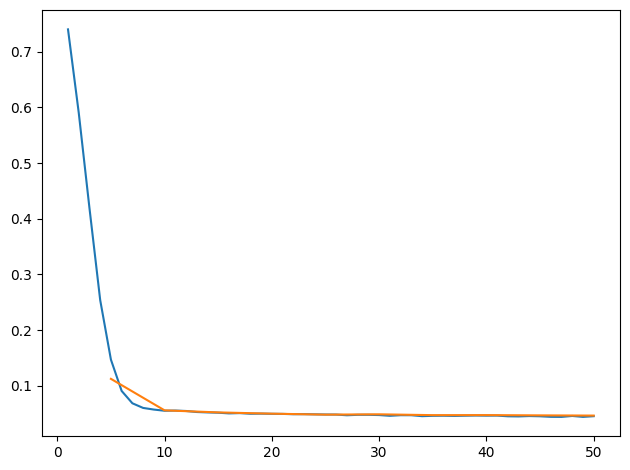

In [11]:
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list)
plt.plot(np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_epoch_loss_list)
plt.tight_layout()
plt.show()

### Plotting sampling process along DDPM's Markov chain

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.66it/s]


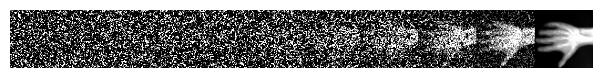

In [12]:
model.eval()
image = torch.randn(
    (1, 1, 64, 64),
)
image = image.to(device)
scheduler.set_timesteps(1000)

intermediary = []
for t in tqdm(scheduler.timesteps):
    # 1. predict noise model_output
    with torch.no_grad():
        model_output = model(image, torch.asarray((t,)).to(device))

    # 2. compute previous image: x_t -> x_t-1
    image, _ = scheduler.step(model_output, t, image)
    if t % 100 == 0:
        intermediary.append(image)

chain = torch.concat(intermediary, dim=-1)
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()